In [22]:
!ls /kaggle/input
!ls /kaggle/input/lpips-offline-wheels
!pip install --no-index --find-links /kaggle/input/lpips-offline-wheels/wheels_dir lpips


import shutil
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import os
import sys
import argparse
import time
import numpy as np
import cv2
import glob
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
from sklearn.model_selection import train_test_split
from PIL import Image

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



alexnetowl  alex-weight  lpips-offline-wheels  nyu-depth-v2
wheels_dir
Looking in links: /kaggle/input/lpips-offline-wheels/wheels_dir
Using device: cuda


Haze Function

In [ ]:
import cv2
import numpy as np
import random

def add_haze(image, beta_range=(0.6, 1.2), A_range=(0.7, 1.0)):
    """
    Adds synthetic haze using simplified atmospheric scattering model.
    I(x) = J(x) * t(x) + A * (1 - t(x))
    t(x) = exp(-beta * d(x)) , here d(x) is approximated as normalized distance

    image: numpy array (H,W,C) in 0-255
    beta_range: scattering coefficient range
    A_range: global atmospheric light range
    """
    image = image.astype(np.float32) / 255.0
    H, W, _ = image.shape
    
   
    beta = random.uniform(*beta_range)
    
   
    A = random.uniform(*A_range)
    
    
    xv, yv = np.meshgrid(np.arange(W), np.arange(H))
    d = np.sqrt((xv / W)**2 + (yv / H)**2)
    
    t = np.exp(-beta * d)
    hazy = image * t[:, :, None] + A * (1 - t[:, :, None])
    hazy = np.clip(hazy, 0, 1)
    hazy = (hazy * 255).astype(np.uint8)
    return hazy


Model Architechture 

In [24]:
class PALayer(nn.Module):
    def __init__(self, channel, mid_channel=None):
        super(PALayer, self).__init__()
        if mid_channel is None:
            mid_channel = channel // 8
        self.pa = nn.Sequential(
            nn.Conv2d(channel, mid_channel, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channel, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel, mid_channel=None, return_attention=False):
        super(CALayer, self).__init__()
        if mid_channel is None:
            mid_channel = channel // 8
        self.return_attention = return_attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, mid_channel, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channel, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return y if self.return_attention else x * y

class ResLayer(nn.Module):
    def __init__(self, channel):
        super(ResLayer, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 1, 1, 0, bias=True)
        self.in1 = nn.InstanceNorm2d(channel, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(channel, channel, 3, 1, 1, bias=True)
        self.in4 = nn.InstanceNorm2d(channel, affine=True)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.in4(self.conv4(y))
        return self.relu(x + y)

class DehazeNet(nn.Module):
    def __init__(self, gps=3, dim=64, kernel_size=3):
        super(DehazeNet, self).__init__()
        self.gps = gps
        self.dim = dim
        self.kernel_size = kernel_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, self.dim, 3, 1, 1, bias=True)
        self.in2 = nn.InstanceNorm2d(self.dim, affine=True)
        self.relu = nn.ReLU(inplace=True)

        self.res1 = ResLayer(self.dim)
        self.res2 = ResLayer(self.dim)
        self.res3 = ResLayer(self.dim)
        self.res4 = ResLayer(self.dim)
        self.res5 = ResLayer(self.dim)
        self.res6 = ResLayer(self.dim)
        self.res7 = ResLayer(self.dim)

        self.ca = CALayer(self.dim * self.gps, mid_channel=self.dim // 16, return_attention=True)
        self.pa = PALayer(self.dim)

        self.conv3 = nn.Conv2d(self.dim, 32, 3, 1, 1, bias=True)
        self.in3 = nn.InstanceNorm2d(32, affine=True)
        self.conv4 = nn.Conv2d(32, 3, 3, 1, 1, bias=True)
        self.in4 = nn.InstanceNorm2d(3, affine=True)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y1 = self.relu(self.in2(self.conv2(y)))
        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)

        y = torch.cat([y1, y2, y3], dim=1)
        w = self.ca(y)
        w = w.view(-1, self.gps, self.dim)[:, :, :, None, None]
        y = w[:, 0, ::] * y1 + w[:, 1, ::] * y2 + w[:, 2, ::] * y3
        y = self.pa(y)

        y = self.relu(self.in3(self.conv3(y)))
        y = self.conv4(y)
        y = x + y
        out = self.relu(y)
        return out

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Data Loader and Splitter

In [ ]:
class NYU2Dataset(Dataset):
    def __init__(self, data_list, transform=None, height=480, width=640):
        self.clean_list = data_list  # <- use the argument here
        self.transform = transform
        self.height = height
        self.width = width
    def __getitem__(self, index):
        clean_path = self.clean_list[index]
        clean_img = cv2.imread(clean_path)
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
        clean_img = cv2.resize(clean_img, (self.width, self.height), interpolation=cv2.INTER_LINEAR)

        # Generate synthetic hazy image
        hazy_img = add_haze(clean_img)

        # Convert BGR to RGB
        hazy_img = cv2.cvtColor(hazy_img, cv2.COLOR_BGR2RGB)
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)

        # Resize
        hazy_img = cv2.resize(hazy_img, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
        clean_img = cv2.resize(clean_img, (self.width, self.height), interpolation=cv2.INTER_LINEAR)

        # Normalize 0-1
        clean_img = clean_img.astype(np.float32) / 255.0
        hazy_img = hazy_img.astype(np.float32) / 255.0

        # To Tensor
        hazy_tensor = torch.from_numpy(hazy_img).float().permute(2,0,1)
        clean_tensor = torch.from_numpy(clean_img).float().permute(2,0,1)

        return hazy_tensor, clean_tensor

    def __len__(self):
        return len(self.clean_list)


def create_dataloaders_from_clean(clean_dir, batch_size=8, img_size=(480,640)):
    
    valid_exts = ['.jpg', '.png', '.jpeg', '.bmp', '.tif', '.tiff']
    clean_files = sorted([x for x in glob.glob(os.path.join(clean_dir, "**/*.*"), recursive=True)
                          if os.path.splitext(x)[1].lower() in valid_exts])
    
    print(f"Total clean images found (including subfolders): {len(clean_files)}")
    
    if len(clean_files) == 0:
        raise ValueError(f"No images found in {clean_dir}. Check your path or extensions!")
    
    # Split 70-15-15
    train_files, temp_files = train_test_split(clean_files, test_size=0.30, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.50, random_state=42)
    
    print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    
    h, w = img_size
    train_ds = NYU2Dataset(train_files, height=h, width=w)
    val_ds = NYU2Dataset(val_files, height=h, width=w)
    test_ds = NYU2Dataset(test_files, height=h, width=w)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader


Training & Evaluation

In [ ]:

# torch hub cache folder
cache_dir = "/root/.cache/torch/hub/checkpoints"
os.makedirs(cache_dir, exist_ok=True)
shutil.copy("/kaggle/input/alexnetowl/alexnet-owt-7be5be79.pth", cache_dir)

# LPIPS directory
lpips_dir = "/root/.lpips"
os.makedirs(lpips_dir, exist_ok=True)
shutil.copy("/kaggle/input/alex-weight/alex.pth", "/root/.lpips/alex.pth")

src = "/kaggle/input/lpips-offline-wheels/wheels_dir"
dst = lpips_dir

for f in os.listdir(src):
    shutil.copy(os.path.join(src, f), dst)

print("LPIPS offline weights copied successfully")


loss_fn_lpips = lpips.LPIPS(
    net='alex',
    pretrained=False   
).to(device)


state_dict = torch.load("/root/.lpips/alex.pth", map_location=device)
loss_fn_lpips.load_state_dict(state_dict, strict=False)


for p in loss_fn_lpips.parameters():
    p.requires_grad = False

loss_fn_lpips.eval()



def calculate_metrics(gt_tensor, pred_tensor):
    """
    Inputs: tensors (B, C, H, W) in range [0, 1]
    """
    # 1. MSE
    mse = nn.MSELoss()(pred_tensor, gt_tensor).item()

    # 2. PSNR
    # Convert to numpy for skimage
    gt_np = gt_tensor.cpu().detach().numpy().transpose(0, 2, 3, 1)
    pred_np = pred_tensor.cpu().detach().numpy().transpose(0, 2, 3, 1)
    
    psnr_val = 0
    ssim_val = 0
    batch_size = gt_np.shape[0]

    for i in range(batch_size):
        p = peak_signal_noise_ratio(gt_np[i], pred_np[i], data_range=1.0)
        s = structural_similarity(gt_np[i], pred_np[i], channel_axis=-1, data_range=1.0)
        psnr_val += p
        ssim_val += s
    
    psnr_val /= batch_size
    ssim_val /= batch_size

    # LPIPS expects input in range [-1, 1], so we normalize our [0,1] images
    
    pred_norm = (pred_tensor * 2) - 1
    gt_norm = (gt_tensor * 2) - 1
    lpips_val = loss_fn_lpips(pred_norm, gt_norm).mean().item()

    return mse, psnr_val, ssim_val, lpips_val

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    metrics = {'mse': 0, 'psnr': 0, 'ssim': 0, 'lpips': 0}
    
    for hazy, clean in loader:
        hazy, clean = hazy.to(device), clean.to(device)
        
        optimizer.zero_grad()
        output = model(hazy)
        loss = criterion(output, clean)
        loss.backward()
        
        # Gradient clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Metrics for reporting
        with torch.no_grad():
            output = torch.clamp(output, 0, 1)
            m, p, s, l = calculate_metrics(clean, output)
            metrics['mse'] += m
            metrics['psnr'] += p
            metrics['ssim'] += s
            metrics['lpips'] += l

    n = len(loader)
    return running_loss/n, {k: v/n for k, v in metrics.items()}

def validate(model, loader):
    model.eval()
    metrics = {'mse': 0, 'psnr': 0, 'ssim': 0, 'lpips': 0}
    
    with torch.no_grad():
        for hazy, clean in loader:
            hazy, clean = hazy.to(device), clean.to(device)
            output = model(hazy)
            output = torch.clamp(output, 0, 1)
            
            m, p, s, l = calculate_metrics(clean, output)
            metrics['mse'] += m
            metrics['psnr'] += p
            metrics['ssim'] += s
            metrics['lpips'] += l
            
    n = len(loader)
    return {k: v/n for k, v in metrics.items()}

LPIPS offline weights copied successfully
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Results Visualization

In [27]:
def visualize_results(model, loader, num_images=10):
    model.eval()
    
    # Collect 10 images
    inputs, preds, gts = [], [], []
    count = 0
    
    with torch.no_grad():
        for hazy, clean in loader:
            hazy, clean = hazy.to(device), clean.to(device)
            output = model(hazy)
            output = torch.clamp(output, 0, 1)
            
            # Unbatch
            for i in range(hazy.size(0)):
                if count >= num_images: break
                inputs.append(hazy[i].cpu().permute(1, 2, 0))
                preds.append(output[i].cpu().permute(1, 2, 0))
                gts.append(clean[i].cpu().permute(1, 2, 0))
                count += 1
            if count >= num_images: break

    # Plot
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 4 * num_images))
    for i in range(num_images):
        # Input
        axes[i, 0].imshow(inputs[i])
        axes[i, 0].set_title("Hazy Input")
        axes[i, 0].axis('off')
        
        # Pred
        axes[i, 1].imshow(preds[i])
        axes[i, 1].set_title("Predicted (Dehazed)")
        axes[i, 1].axis('off')
        
        # GT
        axes[i, 2].imshow(gts[i])
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

In [28]:
# --- CONFIGURATION ---
import threading
import time

def keep_alive(stop_event, interval=60):
    """Prints a message periodically to prevent Kaggle idle timeout."""
    counter = 0
    while not stop_event.is_set():
        time.sleep(interval)
        counter += 1
        print(f"[KeepAlive] Training still running... {counter} min elapsed")



CLEAN_PATH = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train"

BATCH_SIZE = 8
EPOCHS = 10 
LR = 0.0001
IMG_SIZE = (256, 256)
CHECKPOINT_PATH = "last_checkpoint.pth" # Path to save current progress
BEST_MODEL_PATH = "best_dehazer.pth"    # Path for best performing model

# 1. Prepare Data
train_loader, val_loader, test_loader = create_dataloaders_from_clean( CLEAN_PATH, BATCH_SIZE, IMG_SIZE)

# 2. Init Model
model = DehazeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
criterion = nn.SmoothL1Loss().to(device)

# --- RESUME LOGIC ---
start_epoch = 0
best_psnr = 0

if os.path.exists(CHECKPOINT_PATH):
    print(f"--- Found checkpoint at {CHECKPOINT_PATH}. Loading... ---")
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_psnr = checkpoint.get('best_psnr', 0)
    print(f"--- Resuming from Epoch {start_epoch + 1} ---")
else:
    print("--- No checkpoint found. Starting from scratch. ---")
    model.apply(weights_init)

# 3. Training Loop
print("\nStarting Training...")

for epoch in range(start_epoch, EPOCHS):
    start_t = time.time()

    # ---- START KEEP-ALIVE THREAD ----
    stop_event = threading.Event()
    ka_thread = threading.Thread(target=keep_alive, args=(stop_event, 60))
    ka_thread.start()

    # -------- TRAIN --------
    train_loss, train_metrics = train_epoch(
        model, train_loader, criterion, optimizer
    )

    # -------- VALIDATE --------
    val_metrics = validate(model, val_loader)

    # ---- STOP KEEP-ALIVE THREAD ----
    stop_event.set()
    ka_thread.join()

    # Step scheduler
    scheduler.step()

    # Print progress (normal logging)
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Time: {time.time()-start_t:.1f}s | "
        f"Loss: {train_loss:.4f}"
    )
    print(
        f"   Val PSNR: {val_metrics['psnr']:.2f} | "
        f"Best PSNR: {max(best_psnr, val_metrics['psnr']):.2f}"
    )

    # ---- SAVE LAST CHECKPOINT ----
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_psnr': best_psnr,
    }
    torch.save(checkpoint_data, CHECKPOINT_PATH)

    # ---- SAVE BEST MODEL ----
    if val_metrics['psnr'] > best_psnr:
        best_psnr = val_metrics['psnr']
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"--- New Best Model saved with PSNR: {best_psnr:.4f} ---")

print("\nTraining Complete.")


Total clean images found (including subfolders): 101376
Train: 70963, Val: 15206, Test: 15207
--- No checkpoint found. Starting from scratch. ---

Starting Training...
[KeepAlive] Training still running... 1 min elapsed
[KeepAlive] Training still running... 2 min elapsed
[KeepAlive] Training still running... 3 min elapsed
[KeepAlive] Training still running... 4 min elapsed
[KeepAlive] Training still running... 5 min elapsed
[KeepAlive] Training still running... 6 min elapsed
[KeepAlive] Training still running... 7 min elapsed
[KeepAlive] Training still running... 8 min elapsed
[KeepAlive] Training still running... 9 min elapsed
[KeepAlive] Training still running... 10 min elapsed
[KeepAlive] Training still running... 11 min elapsed
[KeepAlive] Training still running... 12 min elapsed
[KeepAlive] Training still running... 13 min elapsed
[KeepAlive] Training still running... 14 min elapsed
[KeepAlive] Training still running... 15 min elapsed
[KeepAlive] Training still running... 16 min e


Evaluating on Test Set...
FINAL TEST RESULTS:
MSE:   0.00108
PSNR:  30.4600
SSIM:  0.9076
LPIPS: 0.1788

Generating Visualization Grid (10 Examples)...


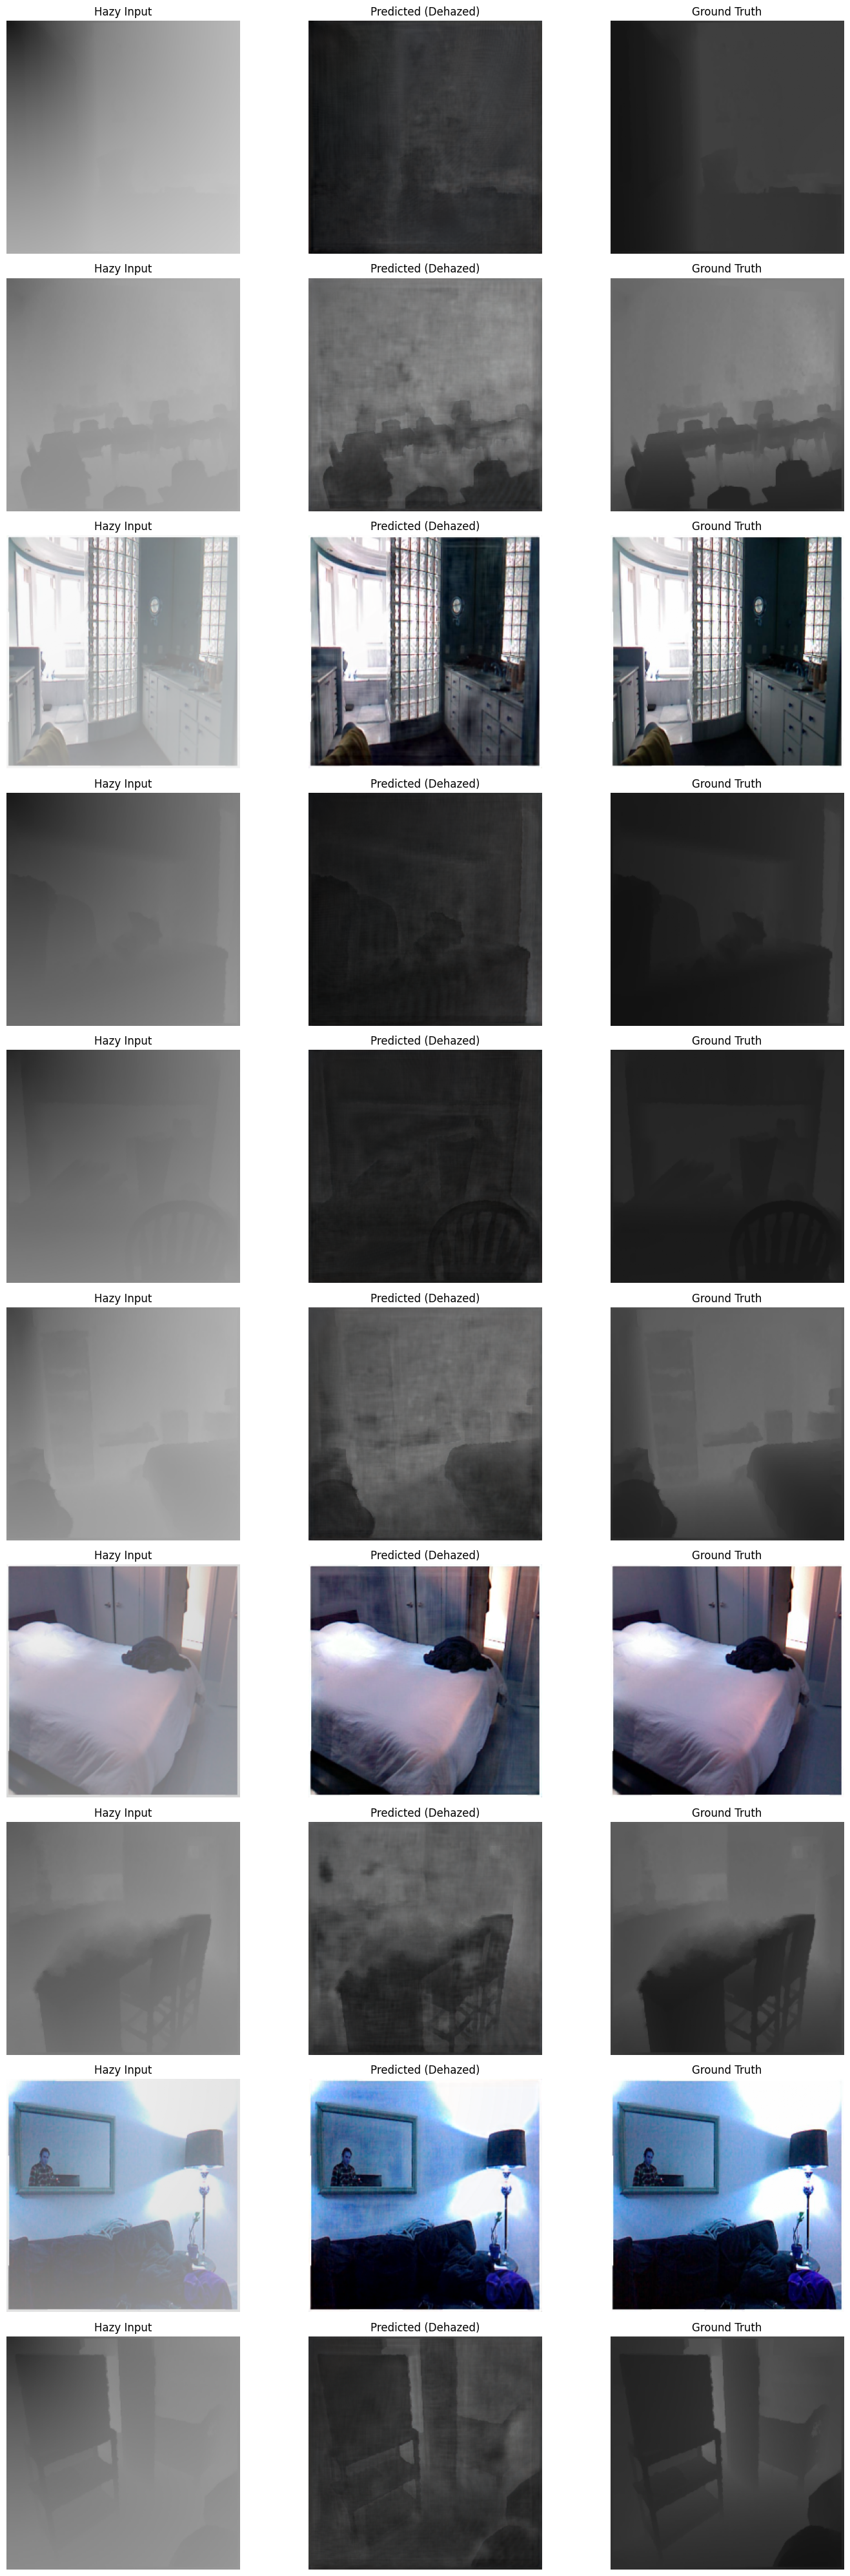

In [29]:
def run_test():
    if os.path.exists("best_dehazer.pth"):
        model = DehazeNet().to(device)
        model.load_state_dict(torch.load("best_dehazer.pth"))

        print("\nEvaluating on Test Set...")
        test_metrics = validate(model, test_loader)

        print("FINAL TEST RESULTS:")
        print(f"MSE:   {test_metrics['mse']:.5f}")
        print(f"PSNR:  {test_metrics['psnr']:.4f}")
        print(f"SSIM:  {test_metrics['ssim']:.4f}")
        print(f"LPIPS: {test_metrics['lpips']:.4f}")

        print("\nGenerating Visualization Grid (10 Examples)...")
        vis_loader = DataLoader(
            test_loader.dataset,
            batch_size=1,
            shuffle=True
        )
        visualize_results(model, vis_loader, num_images=10)
    else:
        print("No model file found. Run training first.")


if __name__ == "__main__":
    run_test()
